In [13]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA as sklearnPCA

from itertools import product
from sklearn import metrics
from collections import Counter
import sys
import json
import csv
import matplotlib
import matplotlib.pyplot as plt
from itertools import cycle

In [14]:
all_files = [i for i in os.listdir('yahoo_stock_dfs/')  if re.match('[A-Z0-9]+\.csv$',i)]
all_files[:5]

['20MICRONS.csv',
 '3IINFOTECH.csv',
 '3MINDIA.csv',
 '63MOONS.csv',
 'A2ZINFRA.csv']

In [2]:
def roll_mean3(series):
    return pd.rolling_mean(series,window=3,center=True)

def roll_mean5(series):
    return pd.rolling_mean(series,window=5,center=True)

def weighted_roll_mean3(series):
    return (pd.rolling_sum(series,window=3,center=True) + series)/4.0

def weighted_roll_mean5(series):
    return (pd.rolling_sum(series,window=3,center=True) + pd.rolling_sum(series,window=5,center=True) + series)/9.0

def min_max(series):
    min_ = np.min(series)
    max_ = np.max(series)
    range_ = max_-min_
    return (series-min_)*100.0/range_

def z_transform(series):
    mean_ = np.mean(series)
    sd_ = np.std(series)
    return (series-mean_)/sd_

def load_csv(path,transformation=None, regularization=None):
    df = pd.read_csv(path, usecols=['Date','Adj Close'],index_col=0)
    colname = path[path.find('/')+1:path.find('.')]
    df.columns = [colname]
    df[colname] = df[colname].interpolate()
    if transformation=='r3':
        #df[colname] = df[colname].interpolate()
        df[colname] = roll_mean3(df[colname])
    elif transformation=='r5':
        #df[colname] = df[colname].interpolate()
        df[colname] = roll_mean5(df[colname])
    elif transformation=='wr3':
        #df[colname] = df[colname].interpolate()
        df[colname] = weighted_roll_mean3(df[colname])
    elif transformation=='wr5':
        #df[colname] = df[colname].interpolate()
        df[colname] = weighted_roll_mean5(df[colname])
    if regularization=='mm':
        df[colname] = min_max(df[colname])
    elif regularization=='z':
        df[colname] = z_transform(df[colname])
    
    return df

In [3]:
def get_kmeans_performance(transformation=None, regularization=None,pca_df=None):
    k_means_performance = []
    for i in range(4,16,2):
        kmeans_model = KMeans(n_clusters=i, random_state=1).fit(all_stocks_t)
        labels = kmeans_model.labels_
        silhoutte_score = metrics.silhouette_score(all_stocks_t, labels, metric='euclidean')
        calinski_score = metrics.calinski_harabaz_score(all_stocks_t, labels) 
        counter = list(enumerate(sorted(Counter(labels).values(),reverse=True)))
        image = get_figure(kmeans_model, 'KMeans_'+str(transformation)+'_'+str(regularization)+'_'+str(i),all_stocks_t,pca_df)
        k_means_performance.append({'1_Algorithm':'K-Means' ,'1_Transformation':str(transformation),'2_Num_Clusters':i, 
                                    '3_Silhoutte_Score':silhoutte_score, '3_Calinski_Score':calinski_score,
                                    'Cluster':dict(counter),'1_Regularization':regularization,
                                    '4_Tuning':'Clusters = '+str(i), '5_Image':image})
    return k_means_performance

In [4]:
def get_affinity_propogation_performance(transformation=None, regularization=None,pca_df=None):
    affinity_propogation_performance = []
    mul_fac = -max(1,abs(all_stocks_t.mean().mean()))*abs(all_stocks_t.std().mean()**(0.75)*800)
    for pref in range(1,30,3):
        affinity_model = AffinityPropagation(preference=pref*mul_fac).fit(all_stocks_t)
        labels = affinity_model.labels_
        n_clusters = len(set(labels))
        if n_clusters >1:
            silhoutte_score = metrics.silhouette_score(all_stocks_t, labels, metric='euclidean')
            calinski_score = metrics.calinski_harabaz_score(all_stocks_t, labels) 
        else:
            silhoutte_score = -1
            calinski_score = -1
        image=''
        if n_clusters<16 and n_clusters>1:
            counter = list(enumerate(sorted(Counter(labels).values(),reverse=True)))
            image = get_figure(affinity_model, 'Affinity_'+str(transformation)+'_'+str(regularization)+'_'+str(pref),all_stocks_t,pca_df)
        
        elif n_clusters<40:
            counter = list(enumerate(sorted(Counter(labels).values(),reverse=True)))[:16]
            
        else:
            counter = {}
        affinity_propogation_performance.append({'1_Algorithm':'Affinity Propogation' ,'1_Transformation':str(transformation),
                                                 '2_Num_Clusters':n_clusters, 
                                                '3_Silhoutte_Score':silhoutte_score, '3_Calinski_Score':calinski_score,
                                                 'Cluster':dict(counter),'1_Regularization':regularization,
                                                '4_Tuning':'Preference = '+str(pref), '5_Image':image})
    return affinity_propogation_performance


In [5]:
def get_mean_shift_performance(transformation=None, regularization=None,pca_df=None):
    mean_shift_performance = []
    for q in np.linspace(start=0.2,stop=0.7,num=6):
#         try:
        bandwidth = estimate_bandwidth(all_stocks_t,quantile=q)
#         except:
#             print ('Mean Shift Failed at q = ',q)
#             continue
        mean_shift_model = MeanShift(bin_seeding=False,bandwidth=bandwidth)
        mean_shift_model.fit(all_stocks_t)
        labels = mean_shift_model.labels_
        n_clusters = len(set(labels))
        if n_clusters >1:
            silhoutte_score = metrics.silhouette_score(all_stocks_t, labels, metric='euclidean')
            calinski_score = metrics.calinski_harabaz_score(all_stocks_t, labels) 
        else:
            silhoutte_score = -1
            calinski_score = -1
        image = ''
        if n_clusters<16 and n_clusters>1:
            counter = list(enumerate(sorted(Counter(labels).values(),reverse=True)))
            image = get_figure(mean_shift_model, 'MeanShift_'+str(transformation)+'_'+str(regularization)+'_'+str(q),all_stocks_t,pca_df)
        
        elif n_clusters<40:
            counter = list(enumerate(sorted(Counter(labels).values(),reverse=True)))[:16]
            
        else:
            counter = {}
        mean_shift_performance.append({'1_Algorithm':'Mean Shift' ,'1_Transformation':str(transformation),
                                                 '2_Num_Clusters':n_clusters, 
                                                '3_Silhoutte_Score':silhoutte_score, '3_Calinski_Score':calinski_score,
                                                 'Cluster':dict(counter),'1_Regularization':regularization,
                                      '4_Tuning':'Quantile = '+str(q), '5_Image':image})
    return mean_shift_performance
        

In [6]:
def flattenjson( b, delim='__' ):
    val = {}
    for i in b.keys():
        if isinstance( b[i], dict ):
            get = flattenjson( b[i], delim )
            for j in get.keys():
                val[ str(i) + delim + str(j) ] = get[j]
        else:
            val[str(i)] = b[i]

    return val

In [7]:
def to_string(s):
    try:
        return str(s)
    except:
        return s.encode('utf-8')


In [8]:
def reduce_item(key, value,reduced_item):
    if type(value) is list:
        i=0
        for sub_item in value:
            reduced_item=reduce_item(key+'_'+to_string(i), sub_item,reduced_item)
            i=i+1
    elif type(value) is dict:
        sub_keys = value.keys()
        for sub_key in sub_keys:
            reduced_item=reduce_item(key+'_'+to_string(sub_key), value[sub_key], reduced_item)
    else:
        reduced_item[to_string(key)] = to_string(value)
    return reduced_item



In [9]:
def convert(json_data, csv_file_path, node=''):
    try:
        raw_data = json.loads(json_data)
    except:
        raw_data=json_data
    try:
        data_to_be_processed = raw_data[node]
    except:
        data_to_be_processed = raw_data
    processed_data = []
    header = []
    for item in data_to_be_processed:
        reduced_item = {}
        reduced_item = reduce_item(node, item,reduced_item)
        header += reduced_item.keys()
        processed_data.append(reduced_item)
    header = list(set(header))
    header.sort()
    file_exists = os.path.isfile(csv_file_path)
    with open(csv_file_path, 'a') as f:
        writer = csv.DictWriter(f, header, quoting=csv.QUOTE_ALL)
        if not file_exists:
            writer.writeheader()
        for row in processed_data:
            writer.writerow(row)
    print ("Finished writing csv file with %d columns" % len(header))

In [10]:
def get_figure(model, filename,X,pca_df):
    
    labels = ['Cluster '+str(i) for i in model.labels_]
    #cluster_centers = model.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    plt.figure(1)
    plt.clf()
    #colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    colors = ['red','green','blue','purple','pink','lightgreen','magenta','lavender','orangered',
              'plum','gold','crimson','tomato','mediumturquoise','mediumseagreen','coral']
#     plt.scatter(pca_df[:,0], pca_df[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        #cluster_center = cluster_centers[k]
        #plt.plot(X.iloc[my_members, 0], X.iloc[my_members, 1], col + '.')
        pca_subset = pca_df[my_members]
        if len(pca_subset)>0:
            plt.scatter(pca_subset[:,0], pca_subset[:,1], label=k , c= col )
#         plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#                  markeredgecolor='k', markersize=14)
    plt.legend()
    plt.title(filename + '\nEstimated number of clusters: %d' % n_clusters_)
    plt.savefig('images/'+filename+'.png')
    return 'images/'+filename+'.png'

In [11]:
def get_pca_featres(df):
    pca_model = sklearnPCA(n_components=2)
    return pca_model.fit_transform(df)

Mean Shift Failed at q =  0.2
Mean Shift Failed at q =  0.3
Mean Shift Failed at q =  0.4
Mean Shift Failed at q =  0.5
Mean Shift Failed at q =  0.6
Mean Shift Failed at q =  0.7
Mean Shift Failed at q =  0.2
Mean Shift Failed at q =  0.3
Mean Shift Failed at q =  0.4
Mean Shift Failed at q =  0.5
Mean Shift Failed at q =  0.6
Mean Shift Failed at q =  0.7
Mean Shift Failed at q =  0.2
Mean Shift Failed at q =  0.3
Mean Shift Failed at q =  0.4
Mean Shift Failed at q =  0.5
Mean Shift Failed at q =  0.6
Mean Shift Failed at q =  0.7


/Users/yasarrafiahmed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=True).mean()
  


Mean Shift Failed at q =  0.2
Mean Shift Failed at q =  0.3
Mean Shift Failed at q =  0.4
Mean Shift Failed at q =  0.5
Mean Shift Failed at q =  0.6
Mean Shift Failed at q =  0.7
Mean Shift Failed at q =  0.2
Mean Shift Failed at q =  0.3
Mean Shift Failed at q =  0.4
Mean Shift Failed at q =  0.5
Mean Shift Failed at q =  0.6
Mean Shift Failed at q =  0.7
Mean Shift Failed at q =  0.2
Mean Shift Failed at q =  0.3
Mean Shift Failed at q =  0.4
Mean Shift Failed at q =  0.5
Mean Shift Failed at q =  0.6
Mean Shift Failed at q =  0.7
Affinity Failed !!!!! Case :  r3 z


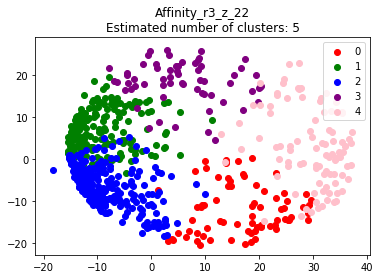

In [13]:
#transformations = [None,'r3','wr3','r5','wr5']
transformations = [None,'r3']
regularizations = [None,'mm','z']
all_performances = []
for transformation,regularization in product(transformations,regularizations):
    all_stocks = load_csv('yahoo_stock_dfs/'+all_files[0],transformation=transformation,regularization=regularization)
    for i in all_files[1:]:
        #print ('yahoo_stock_dfs/'+i)
        temp_csv = load_csv('yahoo_stock_dfs/'+i,transformation=transformation,regularization=regularization)
        if len(temp_csv)>700:
            all_stocks = pd.concat([all_stocks,temp_csv], axis=1)
    all_stocks_t = all_stocks.transpose()
    cols_to_impute = zip(all_stocks_t.columns[1:],all_stocks_t.columns)
    for target,col in cols_to_impute:
        all_stocks_t[target].loc[pd.isnull(all_stocks_t[target])]=all_stocks_t[col].loc[pd.isnull(all_stocks_t[target])]
    cols_to_impute2 = zip(all_stocks_t.columns[-2::-1],all_stocks_t.columns[::-1])
    for target,col in cols_to_impute2:
        all_stocks_t[target].loc[pd.isnull(all_stocks_t[target])]=all_stocks_t[col].loc[pd.isnull(all_stocks_t[target])]
    #print (pd.isnull(all_stocks_t).sum())
    all_stocks_top_features = get_pca_featres(all_stocks_t)
    all_performances = all_performances + get_kmeans_performance(transformation, regularization,all_stocks_top_features)
    try:
        all_performances = all_performances + get_mean_shift_performance(transformation,regularization,all_stocks_top_features)
    except:
        print ('Mean Shift Failed !!!!! Case : ',transformation, regularization)
    try:
        all_performances = all_performances + get_affinity_propogation_performance(transformation, regularization,all_stocks_top_features)
    except:
        print ('Affinity Failed !!!!! Case : ',transformation, regularization)
        pass
        
    

In [14]:
convert(all_performances,'performance.csv')

Finished writing csv file with 24 columns


In [15]:
len(all_performances)

86

In [32]:
get_mean_shift_performance()

TypeError: unhashable type: 'slice'

In [33]:
all_stocks_t

Date,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2017-12-15,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-26,2017-12-27,2017-12-28,2017-12-29
20MICRONS,-0.688964,-0.688964,-0.696275,-0.715772,-0.713335,-0.696275,-0.386760,0.244456,0.980469,1.416715,...,3.005864,3.121236,3.236608,3.447714,3.560632,3.749646,3.739827,3.764374,3.548358,3.548358
3IINFOTECH,3.145058,3.145058,3.145058,3.145058,3.145058,3.145058,3.181560,3.194335,3.183385,3.172434,...,-0.234334,-0.261101,-0.341404,-0.194182,-0.006810,0.367934,0.769446,1.318179,1.933831,1.933831
3MINDIA,-2.162458,-2.162458,-2.186759,-2.214875,-2.213395,-2.198519,-2.182326,-2.191078,-2.166664,-2.143893,...,1.923109,1.923393,1.959333,1.994537,2.088169,2.243430,2.659946,3.004156,3.250798,3.250798
63MOONS,2.600471,2.600471,2.522032,2.482189,2.452308,2.467248,2.470154,2.453553,2.444837,2.432802,...,-0.259420,-0.237321,-0.250070,-0.238596,-0.075825,0.190217,0.387836,0.451159,0.389111,0.389111
A2ZINFRA,-1.459456,-1.459456,-1.459456,-1.459456,-1.459456,-1.459456,-1.459456,-1.459456,-1.459456,-1.459456,...,0.586784,0.598179,0.679573,0.813059,0.920499,0.983986,0.964451,0.951428,0.896080,0.896080
AARTIDRUGS,-1.263529,-1.263529,-1.263529,-1.263529,-1.180880,-1.098230,-1.010218,-0.916843,-0.856806,-0.813453,...,-0.238809,-0.071712,0.096542,0.288866,0.415461,0.533956,0.628382,0.742017,0.876481,0.876481
AARTIIND,-1.634619,-1.634619,-1.640812,-1.658270,-1.661255,-1.663269,-1.657674,-1.648497,-1.638947,-1.618877,...,1.571209,1.727089,1.837969,1.944611,2.132006,2.282569,2.334889,2.241962,2.267543,2.267543
AARVEEDEN,-0.952539,-0.952539,-1.017457,-1.066430,-1.060736,-1.034541,-0.992401,-1.016318,-0.835231,-0.572142,...,-1.025430,-0.965067,-0.911538,-0.846620,-0.819286,-0.781702,-0.782841,-0.757785,-0.748673,-0.748673
ABAN,3.011065,3.011065,2.909044,2.741190,2.613375,2.643597,2.739650,2.746003,2.637437,2.556012,...,-0.672483,-0.666813,-0.660556,-0.653126,-0.651953,-0.631813,-0.594662,-0.559271,-0.544215,-0.544215
ABB,0.166951,0.166951,0.104898,0.030633,0.029885,0.001102,0.023033,-0.018585,-0.024941,-0.022075,...,0.902773,1.017130,1.028882,0.990089,0.954202,0.980106,1.016246,1.038612,1.062747,1.062747


In [27]:
all_stocks[:5]

,20MICRONS,3IINFOTECH,3MINDIA,63MOONS,A2ZINFRA,AARTIDRUGS,AARTIIND,AARVEEDEN,ABAN,ABB,...,NESTLEIND,NETWORK18,NEULANDLAB,NEXTMEDIA,NFL,NIFTYIWIN,NIPPOBATRY,NSIL,NTL,PAPERPROD
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,30.182077,8.75,6504.600098,207.273438,17.75,468.187012,249.088623,46.799999,507.342804,1283.407227,...,6105.145508,67.199997,497.977539,16.950001,35.141209,82.936218,750.334167,779.950012,16.6,180.007233
2015-01-02,30.529570,8.75,6493.450195,205.173859,17.75,468.187012,251.315643,46.250000,503.503448,1270.094971,...,6118.238770,65.550003,503.685455,16.950001,35.614174,83.821625,753.994690,765.049988,16.6,178.995392
2015-01-05,30.628853,8.75,6484.399902,205.320343,17.75,468.187012,247.490997,46.000000,507.539734,1270.390869,...,6121.523438,64.900002,507.805054,16.950001,34.904732,84.492973,757.423645,755.750000,16.6,176.730865
2015-01-06,30.033154,8.75,6333.000000,198.045013,17.75,474.138962,245.070328,43.950001,481.254578,1258.853394,...,6036.392090,62.700001,516.540649,16.950001,34.526360,84.492973,728.045959,755.000000,16.6,173.261795
2015-01-07,30.132437,8.75,6294.899902,200.486404,17.75,480.090912,239.986862,44.099998,460.580872,1240.709106,...,6061.661133,61.700001,515.200562,16.950001,35.566875,83.150269,723.505005,757.700012,16.6,171.671768


In [34]:
q1,q3=np.percentile(all_stocks['ABAN'],[25,75])

In [38]:
np.subtract(q3,q1)

56.0

In [39]:
q3

250.10000600000001

In [41]:
all_stocks['ABAN']

Date
2015-01-01    507.342804
2015-01-02    503.503448
2015-01-05    507.539734
2015-01-06    481.254578
2015-01-07    460.580872
2015-01-08    474.855591
2015-01-09    488.982635
2015-01-12    485.143188
2015-01-13    476.479950
2015-01-14    461.220764
2015-01-15    464.321808
2015-01-16    468.161224
2015-01-19    471.163849
2015-01-20    499.467133
2015-01-21    501.583740
2015-01-22    482.140594
2015-01-23    463.829590
2015-01-27    474.067993
2015-01-28    488.687256
2015-01-29    485.930786
2015-01-30    464.223358
2015-02-02    474.855591
2015-02-03    490.311615
2015-02-04    484.011078
2015-02-05    471.803741
2015-02-06    469.047241
2015-02-09    456.003113
2015-02-10    467.964325
2015-02-11    469.145691
2015-02-12    477.464386
                 ...    
2017-11-17    193.050003
2017-11-20    196.800003
2017-11-21    195.949997
2017-11-22    200.750000
2017-11-23    203.050003
2017-11-24    203.449997
2017-11-27    206.050003
2017-11-28    202.100006
2017-11-29    199.25

# Testing

In [15]:
transformation=None
regularization=None
all_stocks = load_csv('yahoo_stock_dfs/'+all_files[0],transformation=transformation,regularization=regularization)
for i in all_files[1:]:
    #print ('yahoo_stock_dfs/'+i)
    temp_csv = load_csv('yahoo_stock_dfs/'+i,transformation=transformation,regularization=regularization)
    if len(temp_csv)>700:
        all_stocks = pd.concat([all_stocks,temp_csv], axis=1)
all_stocks_t = all_stocks.transpose()
cols_to_impute = zip(all_stocks_t.columns[1:],all_stocks_t.columns)
for target,col in cols_to_impute:
    all_stocks_t[target].loc[pd.isnull(all_stocks_t[target])]=all_stocks_t[col].loc[pd.isnull(all_stocks_t[target])]
cols_to_impute2 = zip(all_stocks_t.columns[-2::-1],all_stocks_t.columns[::-1])
for target,col in cols_to_impute2:
    all_stocks_t[target].loc[pd.isnull(all_stocks_t[target])]=all_stocks_t[col].loc[pd.isnull(all_stocks_t[target])]
all_stocks_t[:5]

Date,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2017-12-15,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-26,2017-12-27,2017-12-28,2017-12-29
20MICRONS,30.182077,30.529570,30.628853,30.033154,30.132437,30.678493,30.380646,36.436916,43.535660,45.372402,...,56.500000,55.650002,56.799999,58.849998,59.950001,59.099998,62.700001,59.750000,59.599998,58.299999
3IINFOTECH,8.750000,8.750000,8.750000,8.750000,8.750000,8.825000,8.900000,8.886364,8.872727,8.859091,...,4.600000,4.600000,4.550000,4.300000,5.150000,5.250000,5.700000,6.650000,7.300000,8.000000
3MINDIA,6504.600098,6493.450195,6484.399902,6333.000000,6294.899902,6494.850098,6438.049805,6409.250000,6433.049805,6610.450195,...,16034.500000,16026.400391,16274.500000,16288.299805,16275.000000,16935.699219,17384.699219,19216.300781,19366.400391,19126.400391
63MOONS,207.273438,205.173859,205.320343,198.045013,200.486404,201.804733,199.802811,200.828186,199.851624,198.777435,...,96.099998,93.349998,94.449997,94.599998,94.699997,113.599998,125.900002,117.949997,121.050003,118.599998
A2ZINFRA,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,...,38.000000,37.599998,38.000000,40.500000,41.700001,41.299999,42.450001,41.099998,40.900002,40.750000


In [19]:
# from sklearn.cluster import MeanShift, estimate_bandwidth
# X=all_stocks_t
# bandwidth = estimate_bandwidth(X,quantile=0.5)

# ms = MeanShift(bin_seeding=False,bandwidth=bandwidth)
# ms.fit(X)

In [26]:
all_stocks_t['2015-01-12'].loc[[True,False,True]]=all_stocks_t['2015-01-08'].loc[[True,False,True]]

In [29]:
pd.isnull(all_stocks_t['2015-01-08'])

20MICRONS     False
3IINFOTECH    False
3MINDIA       False
63MOONS       False
A2ZINFRA      False
AARTIDRUGS    False
AARTIIND      False
AARVEEDEN     False
ABAN          False
ABB           False
ABBOTINDIA    False
ABFRL         False
ABGSHIP       False
ACC           False
ACCELYA       False
ACE           False
ADANIENT      False
ADANIPORTS    False
ADANIPOWER    False
ADFFOODS      False
ADHUNIK       False
ADORWELD      False
ADSL          False
ADVANIHOTR    False
AEGISCHEM     False
AFL           False
AGARIND       False
AGCNET        False
AGRITECH      False
AHLEAST       False
              ...  
NAGAROIL      False
NAGREEKCAP    False
NAGREEKEXP    False
NAHARCAP      False
NAHARPOLY     False
NAHARSPING    False
NATHBIOGEN    False
NATIONALUM    False
NATNLSTEEL    False
NAUKRI        False
NAVINFLUOR    False
NBCC          False
NCC           False
NCLIND        False
NDL           False
NDTV          False
NECLIFE       False
NELCAST       False
NELCO         False


In [24]:
all_stocks_t[:5]

Date,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2017-12-15,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-26,2017-12-27,2017-12-28,2017-12-29
20MICRONS,30.182077,30.529570,30.628853,30.033154,30.132437,30.678493,30.380646,36.436916,43.535660,45.372402,...,56.500000,55.650002,56.799999,58.849998,59.950001,59.099998,62.700001,59.750000,59.599998,58.299999
3IINFOTECH,8.750000,8.750000,8.750000,8.750000,8.750000,8.825000,8.900000,8.886364,8.872727,8.859091,...,4.600000,4.600000,4.550000,4.300000,5.150000,5.250000,5.700000,6.650000,7.300000,8.000000
3MINDIA,6504.600098,6493.450195,6484.399902,6333.000000,6294.899902,6494.850098,6438.049805,6409.250000,6433.049805,6610.450195,...,16034.500000,16026.400391,16274.500000,16288.299805,16275.000000,16935.699219,17384.699219,19216.300781,19366.400391,19126.400391
63MOONS,207.273438,205.173859,205.320343,198.045013,200.486404,201.804733,199.802811,200.828186,199.851624,198.777435,...,96.099998,93.349998,94.449997,94.599998,94.699997,113.599998,125.900002,117.949997,121.050003,118.599998
A2ZINFRA,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,17.750000,...,38.000000,37.599998,38.000000,40.500000,41.700001,41.299999,42.450001,41.099998,40.900002,40.750000


In [20]:
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# print("number of estimated clusters : %d" % n_clusters_)

# # #############################################################################
# # Plot result
# import matplotlib.pyplot as plt
# from itertools import cycle

# plt.figure(1)
# plt.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     my_members = labels == k
#     cluster_center = cluster_centers[k]
#     plt.plot(X.iloc[my_members, 0], X.iloc[my_members, 1], col + '.')
#     plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#              markeredgecolor='k', markersize=14)
# plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

In [21]:
    colors = ['red','green','blue','purple','pink','lightgreen','magenta','lavender','orangered',
              'plum','gold','crimson','tomato','mediumturquoise','mediumseagreen','coral']


In [44]:
import pandas as pd
import numpy as np
incomplete_df = pd.DataFrame({'id': [1,2,3,2,2,3,1,1,1,2,4],
                              'type': np.random.randint(100,1000,11),
                         'amount': [345,928,np.NAN,645,113,942,np.NAN,539,np.NAN,814,np.NAN] 
                         }, columns=['id','type','amount'])
incomplete_df

,id,type,amount
0,1,763,345.0
1,2,268,928.0
2,3,826,NaN
3,2,296,645.0
4,2,984,113.0
5,3,426,942.0
6,1,801,NaN
7,1,651,539.0
8,1,898,NaN
9,2,669,814.0


In [46]:
incomplete_df.mean(axis=1)

0     369.666667
1     399.333333
2     414.500000
3     314.333333
4     366.333333
5     457.000000
6     401.000000
7     397.000000
8     449.500000
9     495.000000
10     74.000000
dtype: float64

In [51]:
incomplete_df.fillna(incomplete_df.mean(axis=1),axis=0)

,id,type,amount
0,1,763,345.0
1,2,268,928.0
2,3,826,NaN
3,2,296,645.0
4,2,984,113.0
5,3,426,942.0
6,1,801,NaN
7,1,651,539.0
8,1,898,NaN
9,2,669,814.0


In [23]:
pca_f[:,0]

array([ -6.11365045e+00,   1.86357493e+01,  -1.16245171e+01,
         2.91189862e+01,  -1.15422374e+01,   1.94229549e+01,
        -1.52824384e+01,   5.65606711e+00,   2.91680047e+01,
         2.52417733e+00,   8.52603951e+00,   1.29845471e+01,
         3.42161165e+01,  -5.90315489e+00,  -1.27691896e+01,
        -8.68375792e+00,   1.08335029e+01,  -1.69141578e+00,
         1.86741815e+01,  -1.40806881e+01,   3.64137695e+01,
        -1.15909611e+01,   1.73718999e+01,  -8.58529670e+00,
        -1.50508321e+01,   3.22610014e+01,  -1.30645491e+01,
         2.54193734e+00,  -1.29790966e+01,  -1.20249833e+01,
        -9.42045915e+00,  -1.04426628e+01,  -1.00874939e+01,
        -4.83594855e+00,   4.98082294e+00,  -1.12667916e+01,
        -1.01627251e+01,  -1.17993682e+01,   2.32124892e+01,
         3.35290262e+01,   1.01214772e+01,  -1.27614870e+01,
        -1.08438599e+01,  -9.79154837e+00,  -6.92582625e-01,
        -1.42681621e+01,  -1.17444185e+01,   3.43783523e+01,
         3.37011710e+00,

In [4]:
help(KMeans)

Help on class KMeans in module sklearn.cluster.k_means_:

class KMeans(sklearn.base.BaseEstimator, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin)
 |  K-Means clustering
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, optional, default: 8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  max_iter : int, default: 300
 |      Maximum number of iterations of the k-means algorithm for a
 |      single run.
 |  
 |  n_init : int, default: 10
 |      Number of time the k-means algorithm will be run with different
 |      centroid seeds. The final results will be the best output of
 |      n_init consecutive runs in terms of inertia.
 |  
 |  init : {'k-means++', 'random' or an ndarray}
 |      Method for initialization, defaults to 'k-means++':
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up co

In [25]:
# labels=np.random.randint(0,10,705)

In [26]:
# n_clusters_=10

In [27]:
# for k, col in zip(range(n_clusters_), colors):
#         my_members = labels == k
#         #cluster_center = cluster_centers[k]
#         #plt.plot(X.iloc[my_members, 0], X.iloc[my_members, 1], col + '.')
#         plt.scatter(pca_f[my_members][:,0:1], pca_f[my_members][:,1:2], label=k , c= col )
# plt.legend()

In [28]:
# my_members = labels == k
# pca_f[my_members]

In [29]:
# def get_figure(model, filename,X,pca_df):
    
#     labels = ['Cluster '+str(i) for i in model.labels_]
#     plt.figure(1)
#     plt.clf()
#     #colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
#     colors = ['red','green','blue','purple','pink','lightgreen','magenta','lavender','orangered',
#               'plum','gold','crimson','tomato','mediumturquoise','mediumseagreen','coral']


#     #plt.scatter(pca_df[:,0], pca_df[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
#     plt.scatter(pca_df[:,0], pca_df[:,1], c=labels)
#     plt.title(filename + '\nEstimated number of clusters: %d' % n_clusters_)
#     plt.savefig('images/'+filename+'.png')
#     return 'images/'+filename+'.png'